In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# 평가기준

## 1.Transformer와 비교해 변경이 필요한 부분을 서술하였다.



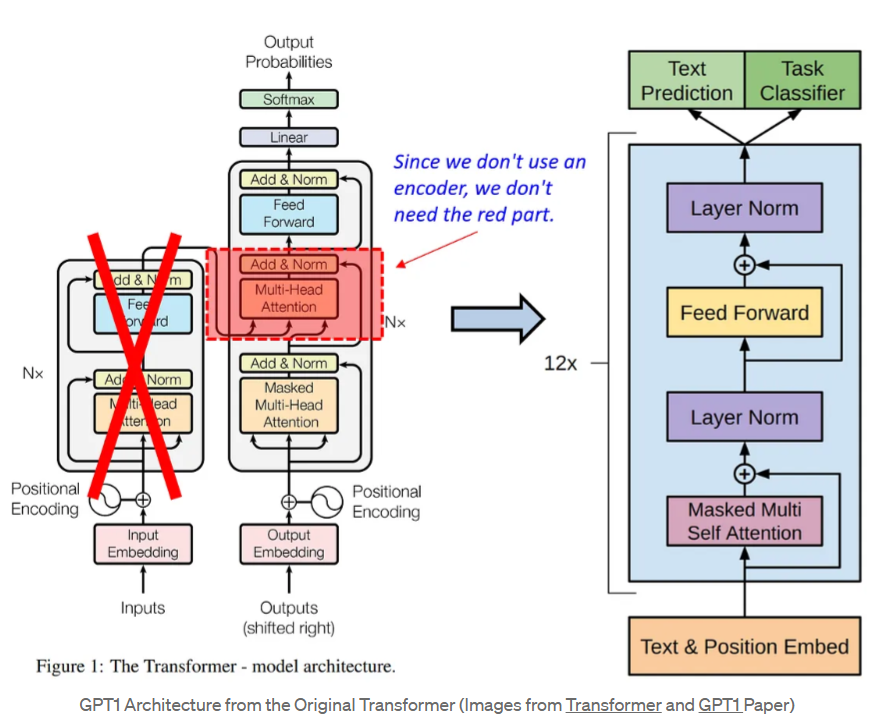

- 인코더와 디코더로 구성되는 Transformer 모델과 달리 GPT는 디코더만 사용하여 모델 구성
- Transformer 모델에서 인코더(인코더 셀프 어탠션)와 인코더 출력을 입력받아서 처리하는 부분(디코더의 인코더-디코더 어탠션) 삭제
- 인코더 값을 처리하는 디코더 코드 수정 및 gpt 맞게 입력 데이터 수정
- Transformer는 문장 전체를 입력받아서 다음 답변을 생성하지만 GPT는 다음 단어씩 예측하는 Autoregressive 방식으로 동작

## 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.

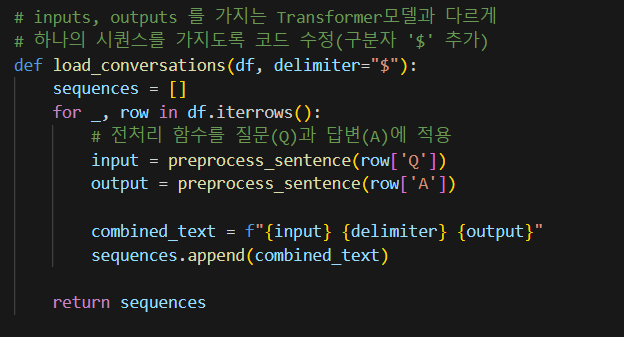

## 3.모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.

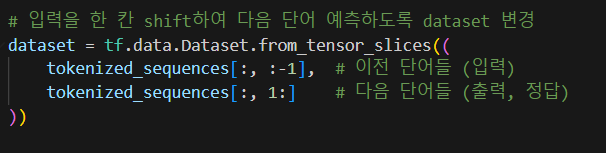

## 4.GPT 모델을 정상적으로 구성하였다. (model.summary, model.fit 결과 캡처 첨부)

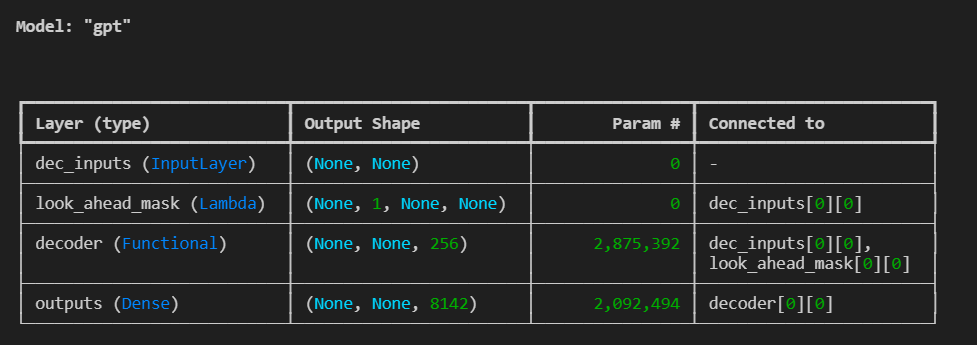

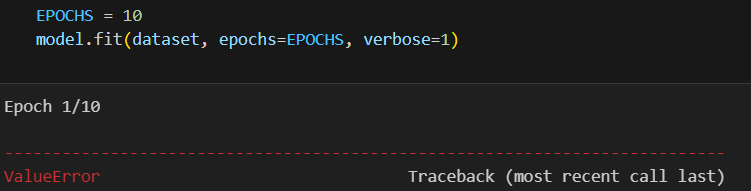

## 5.입력에 따른 출력이 생성되었다.

# 코드 구현

## Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용. songys/Chatbot_data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 데이터 로드
import pandas as pd

path_to_dataset = '/content/drive/MyDrive/data'

path_to_kor = os.path.join(path_to_dataset, 'ChatbotData.csv')


chatbot_df = pd.read_csv(path_to_kor)
chatbot_df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [6]:
len(chatbot_df)

11823

## Step 2. 데이터 전처리하기
1. 대소문자 통일이 불필요(삭제)
2. 전처리 시 데이터 한글만 남기도록 정규표현식 사용([^가-힣.,?!])
3. 기존 파일에서 직접 업로드하는 형식 -> 데이터프레임 형식으로 데이터 핸들링

In [7]:
def preprocess_sentence(sentence):
    # 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣.,?!]", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [24]:
# inputs, outputs 를 가지는 Transformer모델과 다르게
# 하나의 시퀀스를 가지도록 코드 수정(구분자 '$' 추가)
def load_conversations(df, delimiter="$"):
    sequences = []
    for _, row in df.iterrows():
        # 전처리 함수를 질문(Q)과 답변(A)에 적용
        input = preprocess_sentence(row['Q'])
        output = preprocess_sentence(row['A'])

        combined_text = f"{input} {delimiter} {output}"
        sequences.append(combined_text)

    return sequences

In [33]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
input_texts = load_conversations(chatbot_df)
print('전체 샘플 수 :', len(input_texts))

전체 샘플 수 : 11823


In [34]:
print('전처리 후의 22번째 샘플: {}'.format(input_texts[21]))

전처리 후의 22번째 샘플: 가스비 장난 아님 $ 다음 달에는 더 절약해봐요 .


## Step 3. SubwordTextEncoder 사용하기
- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다.
- 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.



In [35]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성했던 기존과 달리
# 하나의 sequences(input_texts)에 대한 Vocab 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(input_texts, target_vocab_size=2**13)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8140]
END_TOKEN의 번호 : [8141]


In [36]:
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8142


In [37]:
print('정수 인코딩 후의 21번째 샘플: {}'.format(tokenizer.encode(input_texts[21])))

정수 인코딩 후의 21번째 샘플: [5755, 617, 2495, 4159, 2, 2364, 7490, 9, 6256, 100, 1]


In [107]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [108]:
# gpt는 패딩이 필요없으므로 시작, 종료 토큰만 추가
def tokenize_and_filter(input_texts, add_special_tokens=False):
    tokenized_sequences = []

    for sentence in input_texts:
        tokenized_sentence = START_TOKEN+ tokenizer.encode(sentence) + END_TOKEN
        tokenized_sequences.append(tokenized_sentence)

    # 모든 시퀀스를 max_length로 패딩 (배치 처리 시 필요)
    tokenized_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_sequences, maxlen=MAX_LENGTH, padding='post')

    return tokenized_sequences

In [109]:
# # gpt는 패딩이 필요없으므로 시작, 종료 토큰만 추가
# def tokenize_and_filter(input_texts, add_special_tokens=False):
#     tokenized_sequences = []

#     for sentence in input_texts:
#         tokenized_sentence = START_TOKEN+ tokenizer.encode(sentence) + END_TOKEN
#         tokenized_sequences.append(tokenized_sentence)

#     return tokenized_sequences

In [110]:
tokenized_sequences = tokenize_and_filter(input_texts)
print('단어장의 크기 :',(VOCAB_SIZE))
print('샘플 개수: {}'.format(len(tokenized_sequences)))

단어장의 크기 : 8142
샘플 개수: 11823


## Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### PositionalEncoding()
문장 내 단어 위치 정보를 인코딩

In [85]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    # def call(self, inputs):
    #     return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
    def call(self, inputs):
        # 🚨 SparseTensor → Dense Tensor 변환 추가
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)

        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### scaled_dot_product_attention()
어텐션 점수 계산(Q,K,V)

In [65]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### MultiHeadAttention()
어탠션 병렬 수행


In [66]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.query_dense(key)
        value = self.query_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### create_padding_mask()
패딩된 부분 무시(0으로 된 토큰을 1로 표시. 계산 시 패딩 영향 제거)

In [67]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### create_look_ahead_mask()
디코더가 미래 단어를 참고하지 않도록 마스킹

In [68]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### decoder_layer()
단일 디코더 층

In [69]:
# 인코더 관련 입력 삭제
# enc_outputs, padding_mask, attention2(인코더-디코더 어텐션)
# 기존 attention2를 제거하고 attention1와 다음 층을 연결

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

### decoder()
여러 디코더 층을 쌓은 디코더

In [70]:
# 인코더 관련 코드 제거
# enc_outputs,  padding_mask
# **padding_mask** : transformer는 모든 단어를 한번에 계산, gpt는 이전 단어들을 기반으로 다음 단어들 순차적 예측, 즉 시퀀스 끝까지 도달하기전에 예측 종료되기때문에 패딩이 필요가없음

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,name=name)

### gpt()
디코터를 변환한 최종 모델

In [71]:
# transformer -> gpt
# gpt는 디코더 부분만 삭제
# 인코더 부분 삭제 -> 인코더 어탠션, 인코더-디코더 어탠션 부분 삭제 필요
# inputs, enc_outputs, enc_padding_mask, dec_padding_mask... 삭제

def gpt(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt"):
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, look_ahead_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=dec_inputs, outputs=outputs, name=name)

### 모델 컴파일 및 학습

In [115]:
# gpt는 Autogressive방식이므로 한칸씩 예측해야함
# 이전 단어를 기반으로 다음 단어를 예측해야하는 구조라서 y_true는 한칸 shift하여 예측함
# 패딩을 고려할 필요가 없기에 mask 제거
def loss_function(y_true, y_pred):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)


    return tf.reduce_mean(loss)

In [96]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step, tf.float32)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

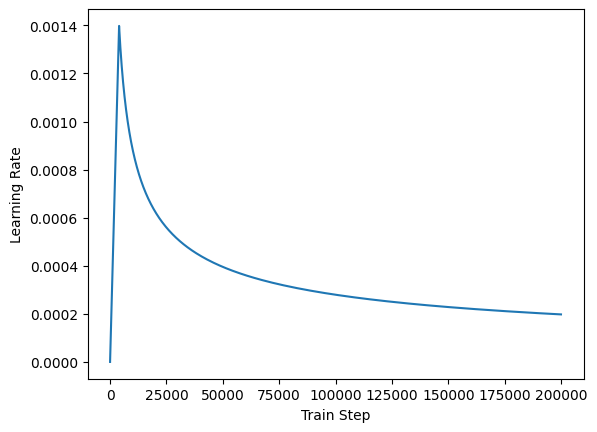

In [97]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [111]:
import tensorflow as tf

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 입력을 한 칸 shift하여 다음 단어 예측하도록 dataset 변경
dataset = tf.data.Dataset.from_tensor_slices((
    tokenized_sequences[:, :-1],  # 이전 단어들 (입력)
    tokenized_sequences[:, 1:]    # 다음 단어들 (출력, 정답)
))


dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
# batch() → padded_batch() 사용 (SparseTensor 방지)
dataset = dataset.padded_batch(BATCH_SIZE, padding_values=0, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [99]:
# import tensorflow as tf

# BATCH_SIZE = 64
# BUFFER_SIZE = 20000

# # 입력을 한 칸 shift하여 다음 단어 예측하도록 dataset 변경
# dataset = tf.data.Dataset.from_generator(
#     lambda: ((seq[:-1], seq[1:]) for seq in tokenized_sequences),
#     output_signature=(
#         tf.TensorSpec(shape=(None,), dtype=tf.int32),  # 입력 (가변 길이)
#         tf.TensorSpec(shape=(None,), dtype=tf.int32)   # 정답 (가변 길이)
#     )
# )

# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

- 해당 코드 수정 당시 길이가 다른 리스트로 구성되어있어서 numpy로 변환하는 과정에서 에러발생.
- 넘파이 배열이 동일한 길이를 가져야하지만 gpt 모델 특성상 패딩이 불필요하다고 생각하여 길이가 일정하지 않았음
- tf.data.Dataset.from_generator() 를 사용하여 가변 길이 시퀀스 처리하도록 변경함
- 이후 모델 구조 설계할 때 - PositionalEncoding() 에서 입력값과 pos_encoding하는 부분에서 SparseTensor 에러 발생
- 결론 : GPT 모델 학습엔 패딩이 필요없지만 배치 생성와 어탠션 연산 시 패딩이 필요하기에 MAX_LENGTH를 추가로 구해서 패딩처리해줌

In [112]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dec_inputs (InputLayer)   │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ look_ahead_mask (Lambda)  │ (None, 1, None, None)  │              0 │ dec_inputs[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, None, 256)      │      2,875,392 │ dec_inputs[0][0],      │
│                           │                        │                │ look_ahead_mask[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputs (Dense)           │ (None, None, 8142)     │      2,092,494 │ decoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,967,886 (18.95 MB)

 Trainable params: 4,967,886 (18.95 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, tf.argmax(y_pred, axis=-1))


dataset = dataset.map(lambda x, y: (x, y[:, :-1]))

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [121]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(64, 37), output.shape=(64, 39, 8142)

In [ ]:
def decoder_inference(sentence, model):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [ ]:
def sentence_generation(sentence, model):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence, model)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
# 테스트용 문자출력 함수
def test_model(model):
    sentence_generation("오늘 날씨 어때?", model)
    print(" ")
    sentence_generation("나 너무 슬퍼", model)
    print(" ")
    sentence_generation("배고파", model)
    print(" ")


In [ ]:
test_model(model)

입력 : 오늘 날씨 어때?
출력 : 저도 좋아해요 .
 
입력 : 나 너무 슬퍼
출력 : 한 잔 드세요 .
 
입력 : 배고파
출력 : 얼른 드세요 .
 


### 학습

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='accuracy',          # 'accuracy' 모니터링
    patience=3,                  # 3 epoch 동안 개선되지 않으면 학습 중단
    restore_best_weights=True,   # 가장 좋은 가중치를 복원
    verbose=1                    # 조기 종료 시 메시지 출력
)


In [ ]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[early_stopping] )

Epoch 1/100
159/159 [==============================] - 4s 27ms/step - loss: 1.7027 - accuracy: 0.3445
Epoch 2/100
159/159 [==============================] - 4s 27ms/step - loss: 1.4687 - accuracy: 0.3698
Epoch 3/100
159/159 [==============================] - 4s 27ms/step - loss: 1.2403 - accuracy: 0.3991
Epoch 4/100
159/159 [==============================] - 4s 27ms/step - loss: 1.0233 - accuracy: 0.4306
Epoch 5/100
159/159 [==============================] - 4s 27ms/step - loss: 0.8235 - accuracy: 0.4633
Epoch 6/100
159/159 [==============================] - 4s 27ms/step - loss: 0.6466 - accuracy: 0.4936
Epoch 7/100
159/159 [==============================] - 4s 27ms/step - loss: 0.4944 - accuracy: 0.5224
Epoch 8/100
159/159 [==============================] - 4s 27ms/step - loss: 0.3698 - accuracy: 0.5471
Epoch 9/100
159/159 [==============================] - 4s 27ms/step - loss: 0.2822 - accuracy: 0.5637
Epoch 10/100
159/159 [==============================] - 4s 27ms/step - loss: 0.220

In [ ]:
test_model(model)

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .
 
입력 : 나 너무 슬퍼
출력 : 이제 그만 아파하면서 해보세요 .
 
입력 : 배고파
출력 : 뭐 좀 챙겨드세요 .
 


## 추가. 하이퍼파라미터 튜닝

In [ ]:
# 하이퍼파라미터 튜닝을 위한 모델 선언 및 컴파일 함수
def train_model(parameter_dic):
    BATCH_SIZE = parameter_dic['BATCH_SIZE']
    BUFFER_SIZE = parameter_dic['BUFFER_SIZE']

    # 디코더는 이전의 target을 다음의 input으로 사용합니다.
    # 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': questions,
            'dec_inputs': answers[:, :-1]
        },
        {
            'outputs': answers[:, 1:]
        },
    ))

    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    tf.keras.backend.clear_session()

    # 하이퍼파라미터
    NUM_LAYERS = parameter_dic['NUM_LAYERS'] # 인코더와 디코더의 층의 개수
    D_MODEL = parameter_dic['D_MODEL'] # 인코더와 디코더 내부의 입, 출력의 고정 차원
    NUM_HEADS = parameter_dic['NUM_HEADS'] # 멀티 헤드 어텐션에서의 헤드 수
    UNITS = parameter_dic['UNITS'] # 피드 포워드 신경망의 은닉층의 크기
    DROPOUT = parameter_dic['DROPOUT'] # 드롭아웃의 비율

    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)

    learning_rate = CustomSchedule(D_MODEL)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

    EPOCHS = parameter_dic['EPOCHS']
    model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[early_stopping] )

    return model


In [ ]:
parameter_dic={
    'BATCH_SIZE' : 32, # 배치 사이즈
    'BUFFER_SIZE' : 20000,# 버퍼 사이즈
    'NUM_LAYERS' : 2, # 인코더와 디코더의 층의 개수
    'D_MODEL' : 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
    'NUM_HEADS' : 8, # 멀티 헤드 어텐션에서의 헤드 수
    'UNITS' : 512, # 피드 포워드 신경망의 은닉층의 크기
    'DROPOUT' : 0.1, # 드롭아웃의 비율
    'EPOCHS' : 200 # 에포크
}

In [ ]:
base_params = {
    'BATCH_SIZE': 64,
    'BUFFER_SIZE': 20000,
    'NUM_LAYERS': 2,
    'D_MODEL': 256,
    'NUM_HEADS': 8,
    'UNITS': 512,
    'DROPOUT': 0.1,
    'EPOCHS': 200
}

# 테스트할 파라미터와 값
test_cases = {
    'BATCH_SIZE': [32, 128],
    'NUM_LAYERS': [3, 4],
    'D_MODEL': [128, 512],
    'NUM_HEADS': [4, 12]
}

# 테스트 문장
test_sentences = [
    "오늘 날씨 어때?",
    "나 너무 슬퍼",
    "배고파"
]

In [ ]:
experiment_results = []

for param, values in test_cases.items():
    for value in values:
        params = base_params.copy()
        params[param] = value

        print(f"\n[실험] {param}={value}")
        model = train_model(params)

        for sentence in test_sentences:
            output = sentence_generation(sentence, model)
            experiment_results.append({
                'Tested_Parameter': param,
                'Value': value,
                'Input_Sentence': sentence,
                'Output_Response': output
            })


[실험] BATCH_SIZE=32
Epoch 1/200
317/317 [==============================] - 13s 22ms/step - loss: 4.7688 - accuracy: 0.1374
Epoch 2/200
317/317 [==============================] - 7s 22ms/step - loss: 3.4950 - accuracy: 0.1969
Epoch 3/200
317/317 [==============================] - 7s 22ms/step - loss: 3.1048 - accuracy: 0.2131
Epoch 4/200
317/317 [==============================] - 7s 21ms/step - loss: 2.8239 - accuracy: 0.2312
Epoch 5/200
317/317 [==============================] - 7s 22ms/step - loss: 2.5301 - accuracy: 0.2578
Epoch 6/200
317/317 [==============================] - 7s 22ms/step - loss: 2.2318 - accuracy: 0.2894
Epoch 7/200
317/317 [==============================] - 7s 22ms/step - loss: 1.9329 - accuracy: 0.3169
Epoch 8/200
317/317 [==============================] - 7s 21ms/step - loss: 1.6444 - accuracy: 0.3437
Epoch 9/200
317/317 [==============================] - 7s 22ms/step - loss: 1.3766 - accuracy: 0.3727
Epoch 10/200
317/317 [==============================] - 7s 22

80/80 [==============================] - 3s 37ms/step - loss: 1.2369 - accuracy: 0.4070
Epoch 21/200
80/80 [==============================] - 3s 37ms/step - loss: 1.0861 - accuracy: 0.4305
Epoch 22/200
80/80 [==============================] - 3s 37ms/step - loss: 0.9433 - accuracy: 0.4530
Epoch 23/200
80/80 [==============================] - 3s 37ms/step - loss: 0.8038 - accuracy: 0.4767
Epoch 24/200
80/80 [==============================] - 3s 37ms/step - loss: 0.6777 - accuracy: 0.5000
Epoch 25/200
80/80 [==============================] - 3s 37ms/step - loss: 0.5574 - accuracy: 0.5208
Epoch 26/200
80/80 [==============================] - 3s 37ms/step - loss: 0.4531 - accuracy: 0.5413
Epoch 27/200
80/80 [==============================] - 3s 38ms/step - loss: 0.3596 - accuracy: 0.5605
Epoch 28/200
80/80 [==============================] - 3s 37ms/step - loss: 0.2851 - accuracy: 0.5755
Epoch 29/200
80/80 [==============================] - 3s 37ms/step - loss: 0.2219 - accuracy: 0.5869
Epo

159/159 [==============================] - 5s 35ms/step - loss: 0.0291 - accuracy: 0.6160
Epoch 57/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0286 - accuracy: 0.6158
Epoch 58/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0264 - accuracy: 0.6163
Epoch 59/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0271 - accuracy: 0.6163
Epoch 60/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0252 - accuracy: 0.6168
Epoch 61/200
159/159 [==============================] - 5s 34ms/step - loss: 0.0260 - accuracy: 0.6166
Epoch 62/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0230 - accuracy: 0.6172
Epoch 63/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0240 - accuracy: 0.6172
Epoch 64/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0217 - accuracy: 0.6178
Epoch 65/200
159/159 [==============================] - 6s 35ms/step - loss: 0.0233 - 

159/159 [==============================] - 7s 44ms/step - loss: 0.0324 - accuracy: 0.6147
Epoch 62/200
159/159 [==============================] - 7s 43ms/step - loss: 0.0309 - accuracy: 0.6150
Epoch 63/200
159/159 [==============================] - 7s 43ms/step - loss: 0.0315 - accuracy: 0.6147
Epoch 64/200
159/159 [==============================] - 7s 42ms/step - loss: 0.0298 - accuracy: 0.6151
Epoch 65/200
159/159 [==============================] - 7s 43ms/step - loss: 0.0310 - accuracy: 0.6151
Epoch 66/200
159/159 [==============================] - 7s 43ms/step - loss: 0.0299 - accuracy: 0.6153
Epoch 67/200
159/159 [==============================] - 7s 43ms/step - loss: 0.0276 - accuracy: 0.6160
Epoch 68/200
159/159 [==============================] - 7s 44ms/step - loss: 0.0267 - accuracy: 0.6161
Epoch 69/200
159/159 [==============================] - 7s 44ms/step - loss: 0.0270 - accuracy: 0.6163
Epoch 70/200
159/159 [==============================] - 7s 44ms/step - loss: 0.0256 - 

159/159 [==============================] - 4s 25ms/step - loss: 0.0251 - accuracy: 0.6165
Epoch 60/200
159/159 [==============================] - 4s 25ms/step - loss: 0.0236 - accuracy: 0.6169
Epoch 61/200
159/159 [==============================] - 4s 25ms/step - loss: 0.0233 - accuracy: 0.6172
Epoch 62/200
159/159 [==============================] - 4s 24ms/step - loss: 0.0233 - accuracy: 0.6170
Epoch 63/200
159/159 [==============================] - 4s 24ms/step - loss: 0.0219 - accuracy: 0.6174
Epoch 64/200
159/159 [==============================] - 4s 24ms/step - loss: 0.0225 - accuracy: 0.6176
Epoch 65/200
159/159 [==============================] - 4s 25ms/step - loss: 0.0203 - accuracy: 0.6181
Epoch 66/200
159/159 [==============================] - 4s 24ms/step - loss: 0.0196 - accuracy: 0.6181
Epoch 67/200
159/159 [==============================] - 4s 24ms/step - loss: 0.0209 - accuracy: 0.6173
Epoch 68/200
159/159 [==============================] - 4s 24ms/step - loss: 0.0188 - 

159/159 [==============================] - 4s 27ms/step - loss: 0.0440 - accuracy: 0.6122
Epoch 40/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0450 - accuracy: 0.6122
Epoch 41/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0406 - accuracy: 0.6129
Epoch 42/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0386 - accuracy: 0.6134
Epoch 43/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0369 - accuracy: 0.6140
Epoch 44/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0340 - accuracy: 0.6147
Epoch 45/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0335 - accuracy: 0.6148
Epoch 46/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0329 - accuracy: 0.6151
Epoch 47/200
159/159 [==============================] - 4s 26ms/step - loss: 0.0299 - accuracy: 0.6154
Epoch 48/200
159/159 [==============================] - 4s 27ms/step - loss: 0.0294 - 

AssertionError: 

In [ ]:
result_list_1 = experiment_results.copy() # 결과값 백업

In [ ]:
# 코드에러 2
'''
 assert d_model % self.num_heads == 0
'D_MODEL' : 256, # 인코더와 디코더 내부의 입, 출력의 고정 차원
256/12 = 0 되지않아서 오류 발생
이후 파라미터 수정
'''

In [ ]:
test_params = {
    'BATCH_SIZE': 64,
    'BUFFER_SIZE': 20000,
    'NUM_LAYERS': 2,
    'D_MODEL': 256,
    'NUM_HEADS': 16, # 16으로 변경 후 진행행
    'UNITS': 512,
    'DROPOUT': 0.1,
    'EPOCHS': 200
}



In [ ]:
test_model = train_model(test_params)
for sentence in test_sentences:
    output = sentence_generation(sentence, model)
    experiment_results.append({
        'Tested_Parameter': param,
        'Value': value,
        'Input_Sentence': sentence,
        'Output_Response': output
    })

Epoch 1/200
159/159 [==============================] - 9s 28ms/step - loss: 5.1997 - accuracy: 0.1106
Epoch 2/200
159/159 [==============================] - 4s 27ms/step - loss: 4.3015 - accuracy: 0.1923
Epoch 3/200
159/159 [==============================] - 4s 27ms/step - loss: 3.5853 - accuracy: 0.1950
Epoch 4/200
159/159 [==============================] - 4s 27ms/step - loss: 3.2398 - accuracy: 0.2040
Epoch 5/200
159/159 [==============================] - 4s 27ms/step - loss: 3.0319 - accuracy: 0.2162
Epoch 6/200
159/159 [==============================] - 4s 27ms/step - loss: 2.8427 - accuracy: 0.2287
Epoch 7/200
159/159 [==============================] - 4s 27ms/step - loss: 2.6398 - accuracy: 0.2471
Epoch 8/200
159/159 [==============================] - 4s 27ms/step - loss: 2.4197 - accuracy: 0.2716
Epoch 9/200
159/159 [==============================] - 4s 27ms/step - loss: 2.1871 - accuracy: 0.2963
Epoch 10/200
159/159 [==============================] - 4s 27ms/step - loss: 1.945

In [ ]:
experiment_results

[{'Tested_Parameter': 'BATCH_SIZE',
  'Value': 32,
  'Input_Sentence': '오늘 날씨 어때?',
  'Output_Response': '날씨 어플에 물어보세요 .'},
 {'Tested_Parameter': 'BATCH_SIZE',
  'Value': 32,
  'Input_Sentence': '나 너무 슬퍼',
  'Output_Response': '저도 슬퍼지네요 . 기운 내길 바랄게요 .'},
 {'Tested_Parameter': 'BATCH_SIZE',
  'Value': 32,
  'Input_Sentence': '배고파',
  'Output_Response': '뭐 좀 챙겨드세요 .'},
 {'Tested_Parameter': 'BATCH_SIZE',
  'Value': 128,
  'Input_Sentence': '오늘 날씨 어때?',
  'Output_Response': '맛있는 거 드세요 .'},
 {'Tested_Parameter': 'BATCH_SIZE',
  'Value': 128,
  'Input_Sentence': '나 너무 슬퍼',
  'Output_Response': '저도 제가 하죠 .'},
 {'Tested_Parameter': 'BATCH_SIZE',
  'Value': 128,
  'Input_Sentence': '배고파',
  'Output_Response': '얼른 맛난 음식 드세요 .'},
 {'Tested_Parameter': 'NUM_LAYERS',
  'Value': 3,
  'Input_Sentence': '오늘 날씨 어때?',
  'Output_Response': '날씨 어플에 물어보세요 .'},
 {'Tested_Parameter': 'NUM_LAYERS',
  'Value': 3,
  'Input_Sentence': '나 너무 슬퍼',
  'Output_Response': '하나씩 사랑이에요 .'},
 {'Tested_Parameter': 'NUM_LA

In [ ]:
result_df = pd.DataFrame(experiment_results)


In [ ]:
result_df

,Tested_Parameter,Value,Input_Sentence,Output_Response
0,BATCH_SIZE,32,오늘 날씨 어때?,날씨 어플에 물어보세요 .
1,BATCH_SIZE,32,나 너무 슬퍼,저도 슬퍼지네요 . 기운 내길 바랄게요 .
2,BATCH_SIZE,32,배고파,뭐 좀 챙겨드세요 .
3,BATCH_SIZE,128,오늘 날씨 어때?,맛있는 거 드세요 .
4,BATCH_SIZE,128,나 너무 슬퍼,저도 제가 하죠 .
5,BATCH_SIZE,128,배고파,얼른 맛난 음식 드세요 .
6,NUM_LAYERS,3,오늘 날씨 어때?,날씨 어플에 물어보세요 .
7,NUM_LAYERS,3,나 너무 슬퍼,하나씩 사랑이에요 .
8,NUM_LAYERS,3,배고파,얼른 맛난 음식 드세요 .
9,NUM_LAYERS,4,오늘 날씨 어때?,친구들과 같이 놀러가세요 .


In [ ]:
# 배치 32 성능 준수
# 배치 128 성능 별로
# 배치가 작을수록 성능 우수

# 레이어갯수(인코더, 디코더의 레이어 수) 3 성능 어색
# 레이어갯수(인코더, 디코더의 레이어 수) 4 성능 이상
# 레이어 깊어질수록 다양한 단어?는 사용하는거 같은데 질문에 맞는 답변은 아님

# D_model(차원 수) 128 낫베드
# D_model(차원 수) 512 몇개 답변이 이상함
# D_model 키우니깐 표현이 풍부해지긴했지만 질문에 맞는 답변은 아님

# NUM_HEADS 변화는 성능적인 변화가 적다.
# 다양한 문맥을 학습한다고 알고있는데 데이터셋이 간단해서 그런가? 큰 성능차이를 느낄수없다.